# CA-RNN Model
MSRP Corpus Paraphrase Detection
Keras Model

In [4]:
import numpy as np
import datetime, time, json
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Dropout, concatenate, LSTM
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from keras.layers.wrappers import Bidirectional
from keras.utils import plot_model

In [5]:
# Initialize global variables
S1_TRAINING_DATA_FILE = 's1_train.npy'
S2_TRAINING_DATA_FILE = 's2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NUM_WORDS_DATA_FILE = 'num_words.json'
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300
MODEL_WEIGHTS_FILE = 'paraphrase_pairs_weights.h5'
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2
RNG_SEED = 13371447
NUM_EPOCHS = 25
DROPOUT = 0.2
BATCH_SIZE = 32
OPTIMIZER = 'adadelta'
HIDDEN_SIZE = 50

In [6]:
# Load the dataset, embedding matrix and word count

s1_data = np.load(open(S1_TRAINING_DATA_FILE, 'rb'))
s2_data = np.load(open(S2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))

with open(NUM_WORDS_DATA_FILE, 'r') as f:
    num_words = json.load(f)['num_words']

In [10]:
print('Shape of sentence data:', s1_data.shape)
print('Shape of label data:',labels.shape)



Shape of sentence data: (5801, 30)
Shape of label data: (5801,)


 # Divide the data into train and test set

In [13]:
# Divide the dataset into train and test sets
X = np.stack((s1_data, s2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)

s1_train = X_train[:,0]
s2_train = X_train[:,1]

s1_test = X_test[:,0]
s2_test = X_test[:,1]

# Define the model

In [15]:
# define the model
sentence1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
sentence2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

s1 = Embedding(num_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=True)(sentence1)
s1 = Bidirectional(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2))(s1)

In [17]:
s2 = Embedding(num_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=True)(sentence2)
s2 = Bidirectional(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2))(s2)

In [18]:
merged = concatenate([s1,s2])

is_paraphrase = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sentence1,sentence2], outputs=is_paraphrase)
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])


# Plot results

In [19]:
tensorboard  = TensorBoard(log_dir='./Graph', 
                                          histogram_freq=0,
                                          write_graph=True, 
                                          write_images=True)

In [20]:
# Train the model, checkpointing weights with best validation accuracy
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True), tensorboard]

history = model.fit([s1_train, s2_train],
                    y_train,
                    epochs=NUM_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-07-14 15:26:21.108810
Train on 3712 samples, validate on 928 samples
Epoch 1/25
 - 45s - loss: 0.6166 - acc: 0.6853 - val_loss: 0.6026 - val_acc: 0.6789
Epoch 2/25
 - 44s - loss: 0.5928 - acc: 0.6961 - val_loss: 0.6005 - val_acc: 0.6789
Epoch 3/25
 - 44s - loss: 0.5838 - acc: 0.7039 - val_loss: 0.6013 - val_acc: 0.6832
Epoch 4/25
 - 43s - loss: 0.5681 - acc: 0.7091 - val_loss: 0.6265 - val_acc: 0.6886
Epoch 5/25
 - 46s - loss: 0.5565 - acc: 0.7196 - val_loss: 0.6203 - val_acc: 0.6897
Epoch 6/25
 - 44s - loss: 0.5414 - acc: 0.7320 - val_loss: 0.6362 - val_acc: 0.6886
Epoch 7/25
 - 44s - loss: 0.5178 - acc: 0.7522 - val_loss: 0.6283 - val_acc: 0.6864
Epoch 8/25
 - 45s - loss: 0.5019 - acc: 0.7645 - val_loss: 0.6344 - val_acc: 0.6789
Epoch 9/25
 - 46s - loss: 0.4661 - acc: 0.7848 - val_loss: 0.6544 - val_acc: 0.6767
Epoch 10/25
 - 48s - loss: 0.4453 - acc: 0.7969 - val_loss: 0.6903 - val_acc: 0.6843
Epoch 11/25
 - 49s - loss: 0.4106 - acc: 0.8184 - val_loss: 0.70

In [21]:
# Print best validation accuracy and epoch
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum validation accuracy = {0:.4f} (epoch {1:d})'.format(max_val_acc, idx+1))

# Evaluate the model with best validation accuracy on the test partition
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([s1_test, s2_test], y_test, verbose=0)
print('Test loss = {0:.4f}, test accuracy = {1:.4f}'.format(loss, accuracy))

Maximum validation accuracy = 0.6897 (epoch 5)
Test loss = 0.5840, test accuracy = 0.7046


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 300)      4961700     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 30, 300)      4961700     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectio

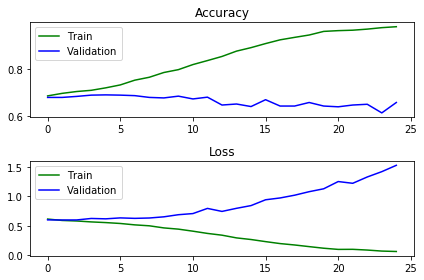

In [23]:
# Plot the loss and accuracy values over time 
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# Print best validation accuracy and epoch

In [24]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 5 = 0.6897


# Evaluate the model with best validation accuracy on the test partition

In [25]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([s1_test, s2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.5840, accuracy = 0.7046


# Save graph of model to a file

In [27]:
plot_model(model, to_file='paraphrase-model.png', show_shapes=True)


<img src="paraphrase-model.png">